In [1]:
# This code splits the given dataset to test-train files.


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
import os

# Apply the default theme
sns.set_theme()
print('Pandas v', pd.__version__)

Pandas v 1.3.5


In [14]:
# Notes about result files:
# 'results_230214_205321.pkl' # classical ML - Dataset: Train Kaggle, Test Kaggle
# 'results_230214_210527.pkl' # classical ML - Dataset: Train Harika, Test Harika
# 'results_230214_211201.pkl' # classical ML- Dataset: Train: Harika.train, Test: Kaggle.test

# 'results_230214_205100.pkl' # bert - Dataset: Train Kaggle, Test Kaggle
# '??.pkl' # bert- Dataset: Train Harika, Test Harika
# 'results_230214_193603.pkl' # bert- Dataset: Train: Harika.train, Test: Kaggle.test
main_folder = Path('../')


results_file = main_folder / 'results_230214_205321.pkl' # classical ML
results_file_bert = main_folder / 'results_230214_205100.pkl' # bert
print(results_file.is_file())
print(results_file_bert.is_file())

True
True


In [26]:

df = pd.read_pickle(results_file_bert)
df

,overall_accuracy,precision,recall,f1,tn,fp,fn,tp,training time,testing time,train size,test size,train data,test data
bert_en_uncased_L-12_H-768_A-12,0.999510,1.000000,0.998694,0.999347,3825,0,3,2294,445.699816,12.528024,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv
bert_en_cased_L-12_H-768_A-12,0.999347,0.999564,0.998694,0.999129,3824,1,3,2294,445.747604,12.606583,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv
small_bert/bert_en_uncased_L-2_H-128_A-2,0.984809,0.982910,0.976491,0.979690,3786,39,54,2243,189.286568,7.640242,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv
small_bert/bert_en_uncased_L-4_H-512_A-8,0.999020,1.000000,0.997388,0.998692,3825,0,6,2291,233.410048,8.639654,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv
small_bert/bert_en_uncased_L-8_H-128_A-2,0.995263,0.997805,0.989552,0.993661,3820,5,24,2273,299.586636,9.358663,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv
small_bert/bert_en_uncased_L-12_H-768_A-12,1.000000,1.000000,1.000000,1.000000,3825,0,0,2297,446.101216,12.750119,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv
bert_multi_cased_L-12_H-768_A-12,0.999837,0.999565,1.000000,0.999782,3824,1,0,2297,480.162748,12.414836,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv
albert_en_base,0.997223,1.000000,0.992599,0.996286,3825,0,17,2280,468.821538,12.415524,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv
electra_base,0.998367,0.997823,0.997823,0.997823,3820,5,5,2292,450.032573,12.994012,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv
electra_small,0.997877,1.000000,0.994340,0.997162,3825,0,13,2284,395.862282,10.741410,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv


In [37]:
df = pd.read_pickle(results_file)
df

,overall_accuracy,precision,recall,f1,tn,fp,fn,tp,train size,test size,train data,test data,training time,testing time
bow_nb,98.513558,0.978317,0.982151,0.980230,3775,50,41,2256,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,0.018950,0.001995
bow_xgboost,98.448220,0.996841,0.961689,0.978950,3818,7,88,2209,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,3.532581,0.028735
bow_svm,98.546227,0.995067,0.966043,0.980340,3814,11,78,2219,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,49.283763,1.819917
boc_nb,92.045083,0.834442,0.983021,0.902658,3377,448,39,2258,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,0.019946,0.004987
boc_xgboost,99.673309,0.999123,0.992164,0.995631,3823,2,18,2279,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,8.836914,0.030918
boc_svm,99.640640,0.997376,0.993034,0.995201,3819,6,16,2281,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,10.323104,1.695526
tfidf_nb,97.141457,0.969469,0.953853,0.961598,3756,69,106,2191,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,0.006985,0.000998
tfidf_xgboost,99.232277,0.999113,0.980409,0.989673,3823,2,45,2252,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,3.184061,0.017095
tfidf_svm,98.546227,0.988928,0.972138,0.980461,3800,25,64,2233,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,34.371813,1.544415
tfidfng_nb,92.273767,0.837029,0.986069,0.905457,3384,441,32,2265,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,0.018949,0.003026


In [47]:
#%%script echo skip
df = pd.read_pickle(results_file)
df2 = pd.read_pickle(results_file_bert)
df_all = pd.concat([df, df2])
df_all
#df_all.loc["small_bert/bert_en_uncased_L-4_H-512_A-8":"electra_small","f1"]+1
#df_acc = (df_all.tn + df_all.tp).div(df_all.tn + df_all.tp + df_all.fn + df_all.fp)*100 #fill the missing accuracies that I forgot to record

#df_all.loc["small_bert/bert_en_uncased_L-4_H-512_A-8":"electra_small","overall_accuracy"] = df_acc.loc["small_bert/bert_en_uncased_L-4_H-512_A-8":"electra_small"]
#df_acc.loc["small_bert/bert_en_uncased_L-4_H-512_A-8":"electra_small"]

#df = df_all
#df

,overall_accuracy,precision,recall,f1,tn,fp,fn,tp,train size,test size,train data,test data,training time,testing time
bow_nb,98.513558,0.978317,0.982151,0.980230,3775,50,41,2256,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,0.018950,0.001995
bow_xgboost,98.448220,0.996841,0.961689,0.978950,3818,7,88,2209,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,3.532581,0.028735
bow_svm,98.546227,0.995067,0.966043,0.980340,3814,11,78,2219,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,49.283763,1.819917
boc_nb,92.045083,0.834442,0.983021,0.902658,3377,448,39,2258,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,0.019946,0.004987
boc_xgboost,99.673309,0.999123,0.992164,0.995631,3823,2,18,2279,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,8.836914,0.030918
boc_svm,99.640640,0.997376,0.993034,0.995201,3819,6,16,2281,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,10.323104,1.695526
tfidf_nb,97.141457,0.969469,0.953853,0.961598,3756,69,106,2191,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,0.006985,0.000998
tfidf_xgboost,99.232277,0.999113,0.980409,0.989673,3823,2,45,2252,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,3.184061,0.017095
tfidf_svm,98.546227,0.988928,0.972138,0.980461,3800,25,64,2233,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,34.371813,1.544415
tfidfng_nb,92.273767,0.837029,0.986069,0.905457,3384,441,32,2265,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,0.018949,0.003026


In [148]:
df = df_all
df.index.rename("Method", inplace=True)

In [65]:
# Fix Nan value of hybrid1_all_ml_averaged

#df.loc["hybrid1_all_ml_averaged"]["training time"] = df.loc["hybrid1_nb":"hybrid1_svm"].sum()["training time"]
#df.loc["hybrid1_all_ml_averaged"]["testing time"] = df.loc["hybrid1_nb":"hybrid1_svm"].sum()["testing time"]
df.at["hybrid1_all_ml_averaged", "training time"] = df.loc["hybrid1_nb":"hybrid1_svm"].sum()["training time"]
df.at["hybrid1_all_ml_averaged", "testing time"] = df.loc["hybrid1_nb":"hybrid1_svm"].sum()["testing time"]
#df

In [66]:
#df_sorted = df.sort_values('f1',ascending=False).reset_index()
#df_sorted

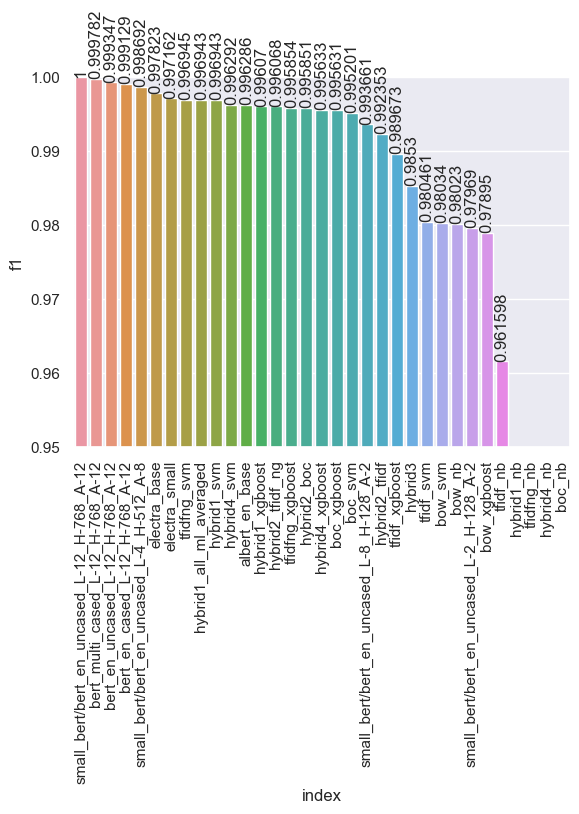

In [72]:
metric = 'f1'
df_sorted = df.sort_values(metric,ascending=False).reset_index()
ax = sns.barplot(data=df_sorted,x="index", y=metric)
ax.tick_params(axis='x', rotation=90)
ax.set(ylim=(0.95, 1))
for i in ax.containers:
    ax.bar_label(i,rotation=90)

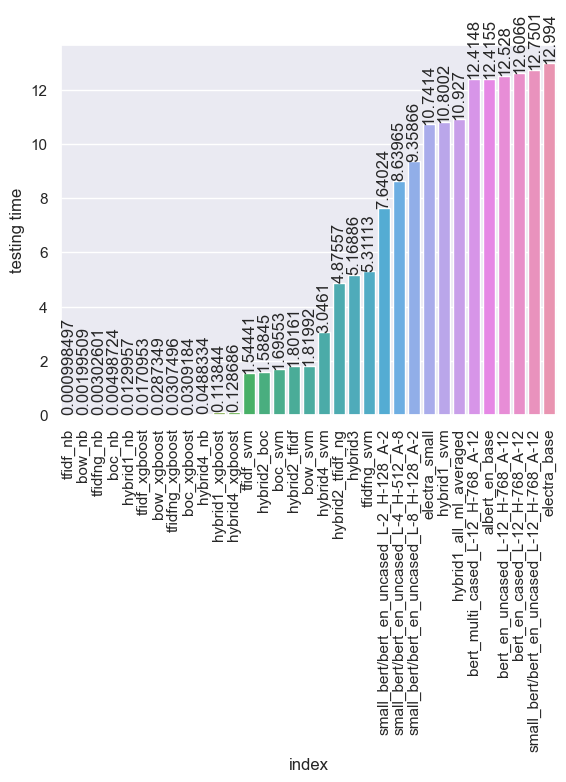

In [77]:
metric = 'testing time'
df_sorted = df.sort_values(metric,ascending=True).reset_index()
ax = sns.barplot(data=df_sorted,x="index", y=metric)
ax.tick_params(axis='x', rotation=90)
#ax.set(ylim=(0.95, 1))
for i in ax.containers:
    ax.bar_label(i,rotation=90)

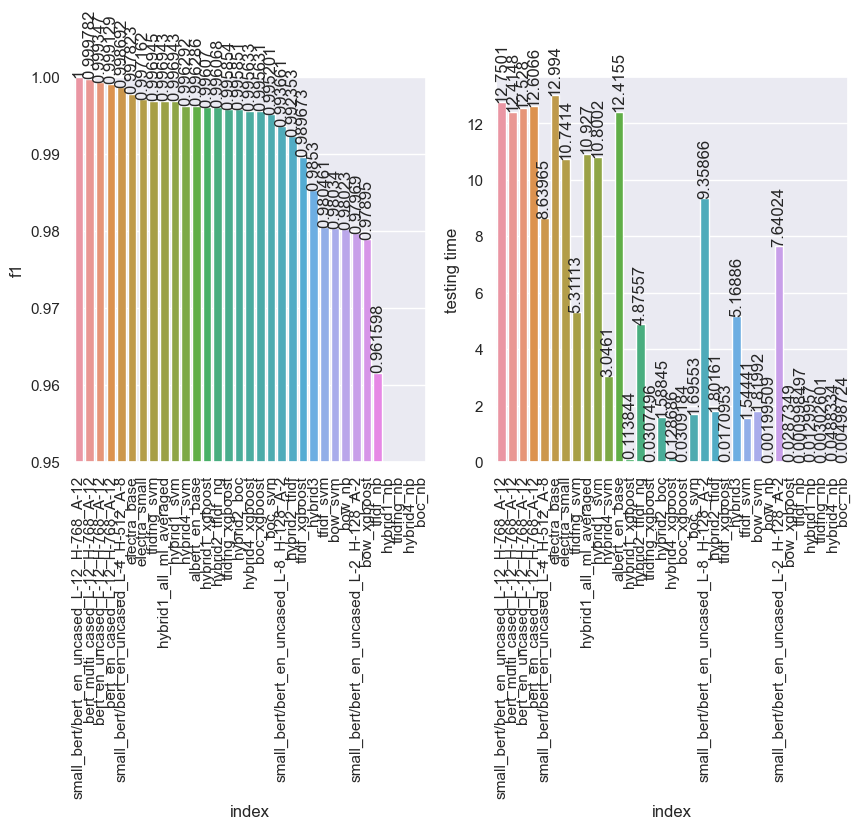

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

metric = 'f1'
df_sorted = df.sort_values(metric,ascending=False).reset_index()
ax = sns.barplot(data=df_sorted,x="index", y=metric, ax=axes[0])
ax.tick_params(axis='x', rotation=90)
ax.set(ylim=(0.95, 1))
for i in ax.containers:
    ax.bar_label(i,rotation=90)

metric = 'testing time'
#df_sorted = df.sort_values('f1',ascending=False).reset_index()
ax = sns.barplot(data=df_sorted,x="index", y=metric, ax=axes[1])
ax.tick_params(axis='x', rotation=90)
#ax.set(ylim=(0.95, 1))
for i in ax.containers:
    ax.bar_label(i,rotation=90)

In [84]:
# experimental
df_sorted = df.sort_values("f1",ascending=False).reset_index()
df_res_index = df_sorted.reset_index()
df_melted = pd.melt(df_res_index, id_vars="index", var_name="metric", value_name="value")
df_melted

,index,metric,value
0,small_bert/bert_en_uncased_L-12_H-768_A-12,level_0,0
1,bert_multi_cased_L-12_H-768_A-12,level_0,1
2,bert_en_uncased_L-12_H-768_A-12,level_0,2
3,bert_en_cased_L-12_H-768_A-12,level_0,3
4,small_bert/bert_en_uncased_L-4_H-512_A-8,level_0,4
...,...,...,...
490,tfidf_nb,testing time,0.000998
491,hybrid1_nb,testing time,0.012996
492,tfidfng_nb,testing time,0.003026
493,hybrid4_nb,testing time,0.048833


# Latex

In [153]:
# Rename Columns and Index properly (for latex tables and figures)
df.index.rename("Method", inplace=True)
column_mapper = {
    "overall_accuracy": "Accuracy", 
    "precision": "Precision",
    "recall":"Recall",
    "f1":"F1",
    "tn":"TN",
    "tp":"TP",
    "fn":"FN",
    "fp":"FP",
    "train size":"Train Size",
    "test size":"Test Size",
    "train data":"Train Data",
    "test data":"Test Data",
    "training time":"Training Time",
    "testing time":"Inference Time"
    }
index_mapper = {
    "bow_nb": "BoW NB",
    "bow_xgboost": "BoW XGboost" #TODO rename all
}
df.rename(columns=column_mapper, index=index_mapper, inplace=True)
df

,Accuracy,Precision,Recall,F1,TN,FP,FN,TP,Train Size,Test Size,Train Data,Test Data,Training Time,Inference Time
Method,,,,,,,,,,,,,,
BoW NB,98.513558,0.978317,0.982151,0.980230,3775,50,41,2256,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,0.018950,0.001995
BoW XGboost,98.448220,0.996841,0.961689,0.978950,3818,7,88,2209,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,3.532581,0.028735
bow_svm,98.546227,0.995067,0.966043,0.980340,3814,11,78,2219,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,49.283763,1.819917
boc_nb,92.045083,0.834442,0.983021,0.902658,3377,448,39,2258,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,0.019946,0.004987
boc_xgboost,99.673309,0.999123,0.992164,0.995631,3823,2,18,2279,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,8.836914,0.030918
boc_svm,99.640640,0.997376,0.993034,0.995201,3819,6,16,2281,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,10.323104,1.695526
tfidf_nb,97.141457,0.969469,0.953853,0.961598,3756,69,106,2191,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,0.006985,0.000998
tfidf_xgboost,99.232277,0.999113,0.980409,0.989673,3823,2,45,2252,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,3.184061,0.017095
tfidf_svm,98.546227,0.988928,0.972138,0.980461,3800,25,64,2233,24487,6122,SQLiV3_train.tsv,SQLiV3_test.tsv,34.371813,1.544415


## Latex Figures

## Latex tables

In [122]:
import pathlib
table_folder=Path(r"C:\Users\3057550\OneDrive - Queen's University Belfast\ECIT\Research\AI_Cybersecurity\Teams Files\Papers\In preparation\NLP for SQLi detection\latex\hybrid_nlp_journal\Tables")
assert (table_folder.is_dir()), "No such folder"



C:\Users\3057550\OneDrive - Queen's University Belfast\ECIT\Research\AI_Cybersecurity\Teams Files\Papers\In preparation\NLP for SQLi detection\latex\hybrid_nlp_journal\Tables\small.tex


In [136]:
def process_style_to_my_latex_format(df_latex):
    # returns style object
    s = df_latex.reset_index().style.hide_index()
    s = s.format(precision=3,
    escape="latex")
    return s

In [147]:
# temp delete me
table_name = "small"
caption="Generated by python"
out_file_name = (table_folder / table_name).with_suffix('.tex') 

df_small = df.loc["bow_nb":"bow_svm",["f1","tp"]]
df_small.index.rename("Method",inplace=True)
print(df_small.index.name)
#print(df_small)

s = process_style_to_my_latex_format(df_small)

# s.to_latex(buf=out_file_name,
#     column_format="l|rr", position="ht", position_float="centering",
#     hrules=True, label=f"tab:{table_name}", caption=caption)

print(s.to_latex(
    column_format="l|rr", position="ht", position_float="centering",
    hrules=True, label=f"table:{table_name}", caption="Styled LaTeX Table")
)


Method
\begin{table}[ht]
\centering
\caption{Styled LaTeX Table}
\label{table:small}
\begin{tabular}{l|rr}
\toprule
{Method} & {f1} & {tp} \\
\midrule
bow\_nb & 0.980 & 2256 \\
bow\_xgboost & 0.979 & 2209 \\
bow\_svm & 0.980 & 2219 \\
\bottomrule
\end{tabular}
\end{table}



In [141]:
df_small.index

Index(['bow_nb', 'bow_xgboost', 'bow_svm'], dtype='object')

End